# MNIST


FC network on the MNIST dataset

# Guided exercise


- The code will run but the network will not train: we will read carefully the code together
and try to figure out where the problem is.

Then you should (we will do it together anyway...)

- Run it and plot training and test loss and error

- Experiment a bit with changing the hidden layer size

- Define a new network with two hidden layers of sizes [30,20] 
and train it for a few epochs

- Write a function to extract representations in both hidden layers

- Change loss function by adding a L2 regularization (see documentation and the implementation of 
    optim.SGD)
  can you make sense of what exactly happens there? This is also key if you want to modify the learning
  rule by yourself, be it applying L1 regularization or define some fancier learning rules.
  On may want, for example, to *block* learning of just one parameter or a group of parameters, but
  not all the parameters of a *group*, like all the parameters in a layer.
  This could be only done (to my knowledge) by customized manipulations such as for example
  *masking*, we will discuss it for the exam.
  
- Make a T-SNE 2D visualization of the representations in the two
hidden layers with $N=1000$ test samples. (Solution: you may want to define a new
loader (custom_loader) for this purpose, and once you have it you may need to sample from it
sample = next(iter(custom_loader)))
)


Now, for the rest of this day, you can experiment by yourself or retrace some of our passages.
You don't have to submit anything, just try whatever you want.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.manifold import TSNE
import numpy as np

In [3]:
class FCNet(nn.Module):
    def __init__(self,din=784, dh=50, dout=10):
        super(FCNet, self).__init__()
        
        self.lin1 = nn.Linear(din, dh)
        self.lin2 = nn.Linear(dh, dout)
    
    def forward(self, x):    
        x = torch.sigmoid(self.lin1(x)) 
        return F.log_softmax(self.lin2(x), dim=1)   

In [4]:
# add another hidden layer

class DeeperFCNet(nn.Module):
    def __init__(self,din=784, dh1=30, dh2=20, dout=10):
        super(DeeperFCNet, self).__init__()
        
        self.lin1 = nn.Linear(din, dh1)
        self.lin2 = nn.Linear(dh1, dh2)
        self.lin3 = nn.Linear(dh2, dout)
    
    def forward(self, x):    
        x = torch.sigmoid(self.lin1(x))
        x = torch.sigmoid(self.lin2(x))
        return F.log_softmax(self.lin3(x), dim=1)
    
    def extract(self, x):
        r1 = torch.sigmoid(self.lin1(x))
        r2 = torch.sigmoid(self.lin2(r1))
        
        return r1, r2

In [5]:
model3 = DeeperFCNet(din=784, dh1=50, dh2=30, dout=10)

In [6]:
input_size = (1,784,)
summary(model3, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 50]          39,250
            Linear-2                [-1, 1, 30]           1,530
            Linear-3                [-1, 1, 10]             310
Total params: 41,090
Trainable params: 41,090
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.16
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


Questions:
- is this a *deep* network? YES
- how many hidden layers do we have? ONE
- what is the number of parameters? SEE BELOW
- how to you forward pass an input data? SEE BELOW

In [7]:
device = torch.device('cpu')
din = 784
dh = 30
dout = 10
input_size = (1,784,)

x = torch.randn(1,784, device=device)
my_model = FCNet(din,dh,dout).to(device)
my_model.forward(x)

tensor([[-2.3884, -2.1439, -2.6430, -2.6344, -2.5840, -2.1734, -2.5428, -2.0796,
         -2.3388, -1.8402]], grad_fn=<LogSoftmaxBackward>)

In [27]:
def train(model, device, train_loader, optimizer, epoch):
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1,784)
        
        # zero grandients before optimizing
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = F.nll_loss(output, target)
        
        
        
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(-1,784)
            output = model(data)
            train_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    acc = 100. * correct / len(train_loader.dataset)        
    train_loss = train_loss/len(train_loader.dataset) 
    return train_loss, acc
        
            

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(-1,784)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
    
    return test_loss, acc
    

In [45]:
# Training settings
input_size=(1,784,)
batch_size=64
test_batch_size=1000
epochs=10
lr=0.01
momentum=0.0   
seed=1
log_interval=100

In [46]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [47]:
# loading of training and test data slightly different

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

In [48]:
model = FCNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [49]:
summary(model,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 50]          39,250
            Linear-2                [-1, 1, 10]             510
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


In [50]:
train_stats = []
test_stats = []
for epoch in range(1, epochs + 1):
    train_stats.append(train(model, device, train_loader, optimizer, epoch))
    test_stats.append(test(model, device, test_loader))

train_stats = np.array(train_stats)
test_stats = np.array(test_stats)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296053
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.076372
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.924007
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.718899
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.612646
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.365947
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.186647
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.115263
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.068990
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.005709

Test set: Average loss: 0.9540, Accuracy: 8334/10000 (83%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.842819
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.845500
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.766790
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.770339
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.718723
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.761374
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.762157
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.772844
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.669273
T

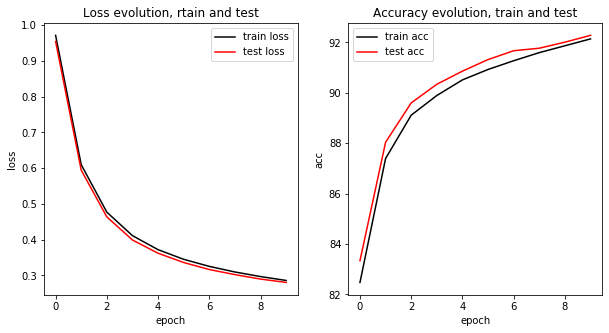

In [51]:
fig=plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title("Loss evolution, rtain and test")
plt.plot(train_stats[:,0],'-k',label='train loss')
plt.plot(test_stats[:,0],'-r',label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(122)
plt.title("Accuracy evolution, train and test")
plt.plot(train_stats[:,1],'-k',label='train acc')
plt.plot(test_stats[:,1],'-r',label='test acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()


plt.show()

In [66]:
model3 = DeeperFCNet().to(device)

In [67]:
optimizer3 = optim.SGD(model3.parameters(), lr=0.05, momentum=momentum)

In [68]:
train_stats = []
test_stats = []
for epoch in range(1, epochs + 1):
    train_stats.append(train(model3, device, train_loader, optimizer3, epoch))
    test_stats.append(test(model3, device, test_loader))

train_stats = np.array(train_stats)
test_stats = np.array(test_stats)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.333845
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.278261
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.246524
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.216999
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.146460
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.050395
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.881836
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.695691
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.504924
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.347467

Test set: Average loss: 1.3627, Accuracy: 6308/10000 (63%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.285577
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.268156
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.076692
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.094959
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.002560
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.971850
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.902571
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.820383
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.677087
T

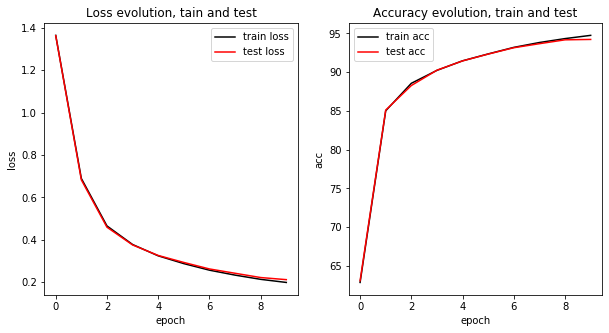

In [69]:
fig=plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title("Loss evolution, tain and test")
plt.plot(train_stats[:,0],'-k',label='train loss')
plt.plot(test_stats[:,0],'-r',label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(122)
plt.title("Accuracy evolution, train and test")
plt.plot(train_stats[:,1],'-k',label='train acc')
plt.plot(test_stats[:,1],'-r',label='test acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()


plt.show()

In [70]:
[s, l] = next(iter(test_loader))

sample = s.view(-1,784) 
labels = l.view(-1,).numpy()

In [71]:
r1, r2 = model3.extract(sample)

In [72]:
pred = model3.forward(sample)

In [98]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(r1.detach().numpy())

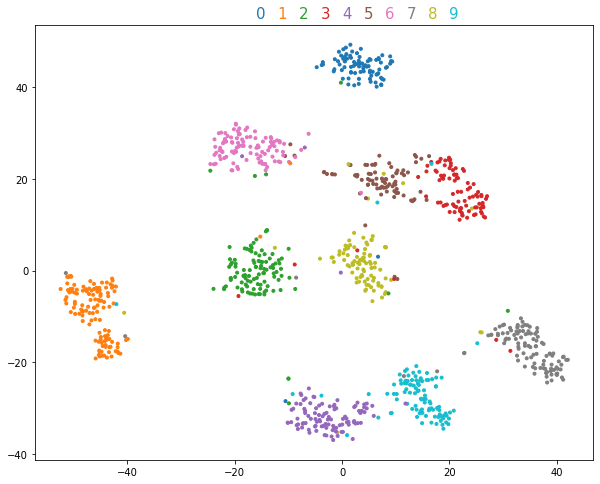

In [99]:
colors = [cm.tab10(x) for x in np.array(labels, dtype=float)/max(labels)]
plt.figure(figsize=(10,8))
plt.scatter(X_embedded[:,0], X_embedded[:,1] ,color=colors[:], marker = '.')
for i in range(10):
    plt.text(4*i - 16 , 55, str(i), color = cm.tab10(i/10), fontsize = 15)

In [94]:
X_embedded = TSNE(n_components=2).fit_transform(r2.detach().numpy())

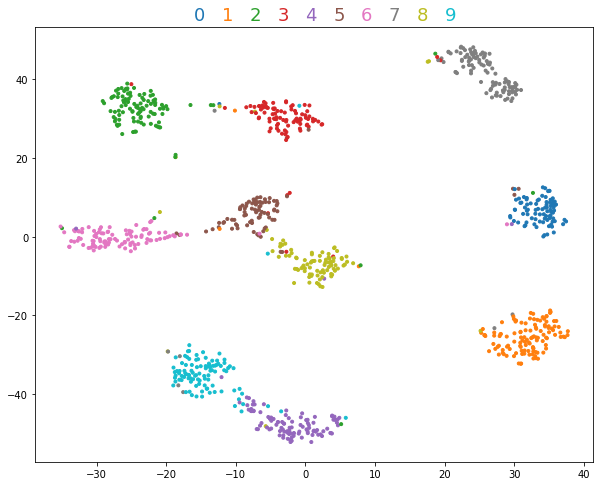

In [95]:
colors = [cm.tab10(x) for x in np.array(labels, dtype=float)/max(labels)]
plt.figure(figsize=(10,8))
plt.scatter(X_embedded[:,0], X_embedded[:,1] ,color=colors[:], marker = '.')
for i in range(10):
    plt.text(4*i -16 , 55, str(i), color = cm.tab10(i/10), fontsize = 18)

In [96]:
X_embedded = TSNE(n_components=2).fit_transform(pred.detach().numpy())

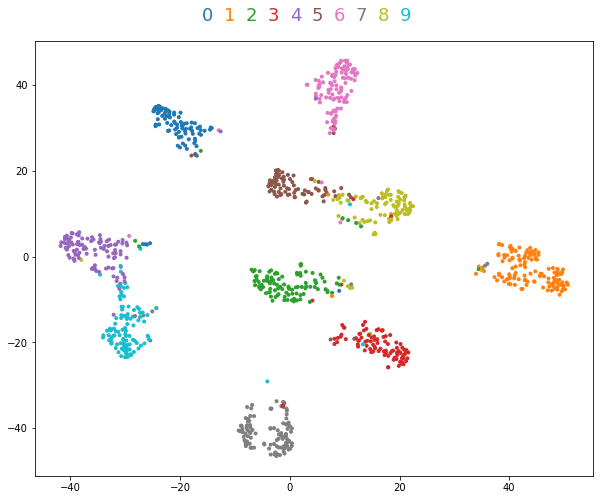

In [97]:
colors = [cm.tab10(x) for x in np.array(labels, dtype=float)/max(labels)]
plt.figure(figsize=(10,8))
plt.scatter(X_embedded[:,0], X_embedded[:,1] ,color=colors[:], marker = '.')
for i in range(10):
    plt.text(4*i -16 , 55, str(i), color = cm.tab10(i/10), fontsize = 18)